# Introduction
In this Notebook i have done binary classification of Sentiment on a dataset that contains annotated Bangla texts.I have tried to use a deep learning based hybrid network with CNN an LSTM.Through hyper parameter tuning,i have achieved an accuracy of 84% with somewhat overfitting.

My main focus of this notebook is to see the impact of hybrid CNN-BiLSTM model in bangla sentiment analysis and newbie Bangla NLP researchers like me can get a better intution.

# Library & Package Import
I have used KERAS to implement CNN and LSTM in this dataset.

In [29]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [30]:
# # Define the Keras model
# model = Sequential()
# model.add(Embedding(num_distinct_words, embedding_output_dims, input_length=max_sequence_length))
# model.add(Bidirectional(LSTM(10), merge_mode='sum'))
# model.add(Dense(1, activation='sigmoid'))

# Predefined Functions 
I have predefined some functions for the preprocessing of my texts.The dataset contains raw text data that have many unwanted things
(Punctuations,English words,emojis etc..).I have cleaned this things with my function.

In [31]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

# Data Import
The data is in excel file.I have about 6500+ in this dataset.The data is either positive or negative.
I have annotated "0" as Negative and "1" as Positive.

In [32]:
#df=pd.read_excel('/kaggle/input/pseudolabel/predicted_unsupervised_sentiment.xlsx')
df=pd.read_csv("/home/ubuntu/Desktop/ML/Coding/dataset/SentNoB Dataset/Train.csv",encoding='utf-8')
# df_test=pd.read_csv("/home/ubuntu/Desktop/ML/Coding/dataset/SentNoB Dataset/Test.csv",encoding='utf-8')
# df=df.append(df_test);
display(df)

,Data,Label
0,মুগ্ধ হয়ে গেলাম মামু. আর তোমায় কি কমু. বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ?...,0
...,...,...
12570,বর্ডারে অনেক লেট হয়ে যাওয়াতে আমরা জিপে করে চলে...,1
12571,আমার সোনার বাংলাতে এমন রক্ষক নামের ভক্ষকের কোন...,2
12572,ওনারা এত হাইজিনিক ও এত সুন্দর পরিবেশে রান্না ক...,1
12573,বাংলাদেশ আমরা পুলিশ চাই না এই ধরনে পুলিশ দরকার...,2


Now we will visualize the ratio of Postive and Negative sentiment.We can see that the ratio is closly 1:1.Which is considered as a good balance.

In [33]:
df.shape

(12575, 2)

In [34]:
df.columns=["sentence","sentiment"]

In [35]:
#df["sentiment"].replace({2:1}, inplace=True)


In [36]:
df_n=df[df.sentiment==0];

In [37]:
df_n

,sentence,sentiment
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ?...,0
5,"যেমন : পরীক্ষার রেজাল্টের সময় , বিভিন্ন ব্যানি...",0
8,আমি ভেবেছিলাম গালিগালাজ করে সেরা ছেলে সে ? গাল...,0
9,"তুমি রেপারই হও , ডাক্তার হওয়ার দরকার নাই তোমার",0
40,ডিপেন্ড করে আপনার লাইফ স্টাইলের উপর । পার হেড ...,0
...,...,...
12557,ঘটনা এখানেই সেস । নতুন কোন নাটক দেখতে মুড়ি খান,0
12559,ফাহিম ভাই সব কিছুর দামটা ইসকিনে দেখা বেন পিলিজ,0
12561,কোথায় কতো টাকা লাগবে সেইটা টুরের আগেই কি করে ব...,0
12566,ডিসেমবরে শেষের দিকে গেলে বরফ পাবো দাদা,0


In [38]:
#df=df.append(df_n)

In [39]:
df

,sentence,sentiment
0,মুগ্ধ হয়ে গেলাম মামু. আর তোমায় কি কমু. বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ?...,0
...,...,...
12570,বর্ডারে অনেক লেট হয়ে যাওয়াতে আমরা জিপে করে চলে...,1
12571,আমার সোনার বাংলাতে এমন রক্ষক নামের ভক্ষকের কোন...,2
12572,ওনারা এত হাইজিনিক ও এত সুন্দর পরিবেশে রান্না ক...,1
12573,বাংলাদেশ আমরা পুলিশ চাই না এই ধরনে পুলিশ দরকার...,2


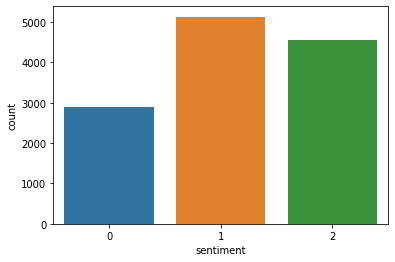

In [40]:
import seaborn as sns

sns.countplot(df['sentiment']);

In [41]:
df

,sentence,sentiment
0,মুগ্ধ হয়ে গেলাম মামু. আর তোমায় কি কমু. বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ?...,0
...,...,...
12570,বর্ডারে অনেক লেট হয়ে যাওয়াতে আমরা জিপে করে চলে...,1
12571,আমার সোনার বাংলাতে এমন রক্ষক নামের ভক্ষকের কোন...,2
12572,ওনারা এত হাইজিনিক ও এত সুন্দর পরিবেশে রান্না ক...,1
12573,বাংলাদেশ আমরা পুলিশ চাই না এই ধরনে পুলিশ দরকার...,2


In [42]:
df_test=pd.read_csv("/home/ubuntu/Desktop/ML/Coding/dataset/SentNoB Dataset/Test.csv",encoding='utf-8')
df_test.columns=["sentence","sentiment"]
df=df.append(df_test);

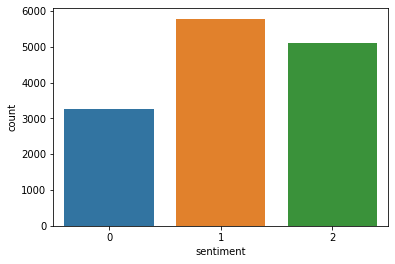

In [43]:
import seaborn as sns

sns.countplot(df['sentiment']);

# Data Preprocessing
At first we will clean the dataset with my predefined function preprocessing().

In [44]:
df['sentence'] = df.sentence.apply(lambda x: preprocessing(str(x)))

In [45]:
df.reset_index(drop=True, inplace=True)

In [46]:

df

,sentence,sentiment
0,মুগ্ধ হয়ে গেলাম মামু আর তোমায় কি কমু বলো তোমায়...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ...,0
...,...,...
14156,ঐ পুলিশ কুওারবাচচাদের গুলিকরে মেরে ফেলা উচিত,2
14157,খিচুড়ি পর্ব মারাত্মক বাকি টা দেখি তারপর কমেন্ট,1
14158,পাশের ফ্রেন্ডটা কি ছেলে না মেয়ে,2
14159,মদ লকমান না খেলেও আমরা খাই এমনটাই মনে হচ্ছে,2


Now I will prepare the dataset to train in the CNN LSTM network.So i have to convert all Sentences into a numpy Array.

I have divided the training and testing data into 80/20 ratio.

I have converted the sentiment values into one hot encodings for the convenient use in model training.


In [47]:
#train1, test1 = train_test_split(df,random_state=69, test_size=0.2)

train1=df[:12570]
test1=df[12570:]
# train1=df[:15469]
# test1=df[15469:]

training_sentences = []
testing_sentences = []



train_sentences=train1['sentence'].values
train_labels=train1['sentiment'].values
for i in range(train_sentences.shape[0]): 
    #print(train_sentences[i])
    x=str(train_sentences[i])
    training_sentences.append(x)
    
training_sentences=np.array(training_sentences)





test_sentences=test1['sentence'].values
test_labels=test1['sentiment'].values

for i in range(test_sentences.shape[0]): 
    x=str(test_sentences[i])
    testing_sentences.append(x)
    
testing_sentences=np.array(testing_sentences)


train_labels=to_categorical(train_labels)


test_labels=to_categorical(test_labels)
print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_sentences.shape))
print("testing_sentences shape: "+str(testing_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))


Training Set Length: 12570
Testing Set Length: 1591
training_sentences shape: (12570,)
testing_sentences shape: (1591,)
train_labels shape: (12570, 3)
test_labels shape: (1591, 3)


The Processed result is here what you see:

In [48]:
print(training_sentences[1])
print(train_labels[0])

এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায় এই তিনটা পুলিশ কে তরে সবার সামনে মেরে পেলা দরকার 
[0. 1. 0.]


Now i will predefine some variables.

vocab_size is the maximum vocabulary length of Tokenizer.

KERAS tokenzier allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

I will be tokenizing my dataset with this class here.I have did this tokenization so that it can be later used to generate Embeddings.

The main advantage of word embedding is that words that share a similar context can be represented close to each other in the vector space. Thus, vectors carry a sense of semantic of a word.

I have predefined the embedding dimension as 300(embedding_dim).

max_length is the sentence maximum length.

trunc_type is the truncation type.

oov_token is the token for the words that are not present in the corpus.oov means out of vocabulary.

In [49]:
# vocab_size = 25000
# embedding_dim = 300
# max_length = 100
vocab_size = 50000
embedding_dim = 300
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"

In [50]:
print(training_sentences.shape)
print(train_labels.shape)

(12570,)
(12570, 3)


At first i will tokenize and then i will be padding the sequences.I have used tokenizer only on training dataset to see how the model performs on unseen words.

In [51]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

23811
Word index length:23811


In [52]:
print("Sentence :--> \n")
print(training_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

ভাই আপনার কথাই যাদু রয়েছে

Sentence Tokenized and Converted into Sequence :--> 

[3, 9, 1380, 11381, 1471]

After Padding the Sequence with padding length 100 :--> 

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     3
     9  1380 11381  1471]


In [53]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (12570, 100)
Padded shape(testing): (1591, 100)


# Model Creation
At first i have created embeddings from the text.

In first layer,i created an conv1D with 200 as filter for CNN.

In second & third layer,i have applied two Bi-LSTM with a dropout of .5.

In rest of the layer i have applied Dense network.

I have used Adap Optimizer with fine tuned hyperparameters.

I have also applied L2 regularizations to reduce overfitting as much as possible.

In [54]:
with tf.device('/gpu:0'):
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Conv1D(200, kernel_size=3, activation = "relu"))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Flatten())
    #l2 regularizer
    model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
    model.add(Dense(3, activation='softmax'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
    
    
    adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    model.summary()
    #model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
    model.compile(loss='mse',optimizer=adam,metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          15000000  
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 200)           180200    
                                                                 
 bidirectional_2 (Bidirectio  (None, 98, 128)          135680    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 98, 128)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 50)               

I trained the model for 5 epochs with batch size 256.

In [55]:
    history=model.fit(padded,train_labels,epochs=25,batch_size=256,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

Epoch 1/25
50/50 [==============================] - 42s 769ms/step - loss: 0.7671 - accuracy: 0.4146 - val_loss: 0.6522 - val_accuracy: 0.5211
Epoch 2/25
50/50 [==============================] - 37s 736ms/step - loss: 0.5397 - accuracy: 0.6215 - val_loss: 0.4567 - val_accuracy: 0.6556
Epoch 3/25
50/50 [==============================] - 37s 739ms/step - loss: 0.3620 - accuracy: 0.7675 - val_loss: 0.3605 - val_accuracy: 0.6348
Epoch 4/25
50/50 [==============================] - 37s 734ms/step - loss: 0.2431 - accuracy: 0.8545 - val_loss: 0.2974 - val_accuracy: 0.6436
Epoch 5/25
50/50 [==============================] - 39s 777ms/step - loss: 0.1599 - accuracy: 0.9122 - val_loss: 0.2620 - val_accuracy: 0.6543
Epoch 6/25
50/50 [==============================] - 38s 757ms/step - loss: 0.1078 - accuracy: 0.9378 - val_loss: 0.2296 - val_accuracy: 0.6719
Epoch 7/25
50/50 [==============================] - 40s 799ms/step - loss: 0.0747 - accuracy: 0.9534 - val_loss: 0.2083 - val_accuracy: 0.6750

# Visualization

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


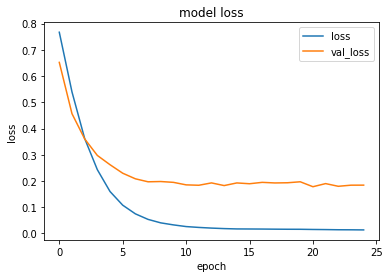

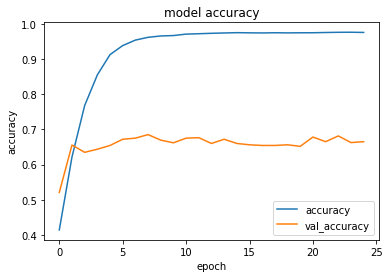

In [56]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

# Accuracy and Evaluation

In [57]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=256)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=256)
print("The test accuracy is: "+str(loss_and_metrics[1]))

50/50 [==============================] - 11s 209ms/step - loss: 0.0126 - accuracy: 0.9768
The train accuracy is: 0.9767701029777527
7/7 [==============================] - 1s 211ms/step - loss: 0.1841 - accuracy: 0.6650
The test accuracy is: 0.6649905443191528


# Conclusion
As we can see that the result is somewhat overfitting.This is because the dataset is very small to work with with deep learning.But my main focus of this notebook was to see what is the result of bangla sentiment analysis if i use a hybrid network.